# Mask Image Classification Model Training and Evaluation

This notebook contains the process for training and evaluating the Mask Image Classification downstream model used for the Crowd Monitoring and Social Distancing Analysis platform (GDP Group 5).

A pre-trained ResNet-50 architecture trained on the ImageNet-21K dataset is used, with the Big Transfer (BiT) fine-tuning process followed for model training.

The process of BiT is based on the paper detailed at: https://arxiv.org/pdf/1912.11370.pdf, and closely follows methodology detailed within the Google research blog at: https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb#scrollTo=EOYOLzWblDSf

---

**Author:** Benjamin David Fraser

**Module:** Group Design Project (Group 5), Cranfield University, Applied Artificial Intelligence MSc.

**Table of Contents:**

1. [Importing dependencies and setting up directories & data](#imports)
2. [Creation of datasets, dataloaders and preprocessing pipelines](#preprocessing)
3. [Development of Mask Image Classification Model](#model-development)
4. [Evaluation of Classification Metrics with trained model](#evaluation)
5. [Saving trained model](#saving)
6. [Inference on new images](#inference)

## 1. Import dependencies and set up directories

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix, f1_score, auc, \
                            classification_report, roc_curve, \
                            precision_recall_curve
from tensorflow import keras
from tqdm import tqdm

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# connect to local drive for data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get our current working directory
INPUT_DIR = os.getcwd()

# define our dir and associated files stored on drive
DRIVE_DATA_DIR = 'drive/MyDrive/ML_Data/Mask_Object_Detection'
DRIVE_DATA_FILENAME = 'mask_classification_ext.zip'

# set paths to images and annotations
drive_data_file = os.path.join(DRIVE_DATA_DIR, DRIVE_DATA_FILENAME)

# unzip dataset move to local instance
!unzip {drive_data_file} -d {INPUT_DIR}

Streaming output truncated to the last 5000 lines.
  inflating: /content/mask_classification_ext/with_mask/MOXA_609_region_0.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_2742_region_8.jpg  
  inflating: /content/mask_classification_ext/with_mask/00003002_region_1.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_2915_region_1.jpg  
  inflating: /content/mask_classification_ext/with_mask/Ocean_city_md_broadwalk2 ocean_city_MD_broadwalk2_24_region_1.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_1095_region_5.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_1039_region_17.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_321_region_22.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_648_region_6.jpg  
  inflating: /content/mask_classification_ext/with_mask/MOXA_1081_region_3.jpg  
  inflating: /content/mask_classification_ext/with_mask/Thrashers_french_fries_ocean_city thrasher

In [ ]:
# define our main folders relative to input DIR
DATA_DIR = os.path.join(INPUT_DIR, 'mask_classification_ext')

## 2. Creation of tensorflow datasets and preprocessing pipelines

In [ ]:
# if images are generally small (smaller than 96 x 96 on avg)
IMG_SIZE = (160, 160)

# if images are larger (at least 96 x 96 on average)
#IMG_SIZE = (384, 384)

BATCH_SIZE = 32

We'll set up our training and validation data for training & optimising our model, as follows:

In [ ]:
# gather our dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=RANDOM_SEED,
  image_size=IMG_SIZE,
  batch_size=None)

Found 11261 files belonging to 2 classes.
Using 9009 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=RANDOM_SEED,
  image_size=IMG_SIZE,
  batch_size=None)

Found 11261 files belonging to 2 classes.
Using 2252 files for validation.


Class names for training & inference are as follows:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['no_mask', 'with_mask']


Lets preview some random instances of the training data, just to ensure we have created the dataset and dataloaders correctly:

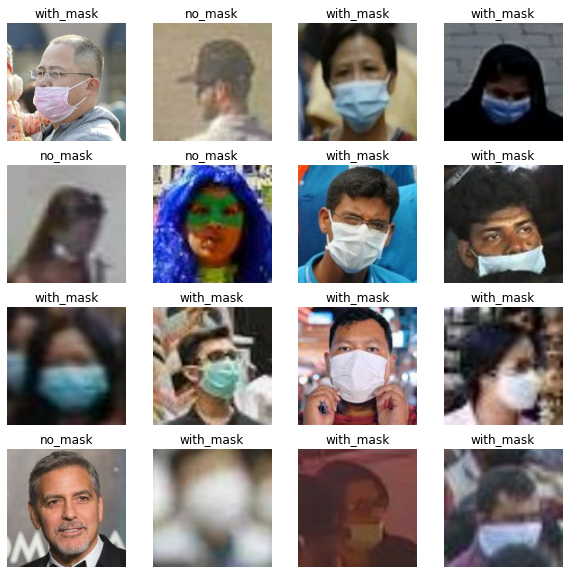

In [ ]:
plt.figure(figsize=(10, 10))
i = 0
for image, label in train_ds.take(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")
    i += 1

We need to set our input preprocessing pipeline up so that it matches the Big Transfer fine-tuning process:

In [ ]:
RESIZE_TO = 160
CROP_TO = 128
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE 
NUM_CLASSES = 2 

# set our schedule length and boundaries (subject to dataset size)
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

Development of our preprocessing functions for training and inference (test):

In [ ]:
@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)

@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)

# we need to ensure there are at least 50 epochs of training
repeat_count += 50 + 1 

Lets use these preprocessing functions to create our final train and test data pipelines:

In [ ]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(8000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

As before, lets load some random data and ensure we can visualise the data, which confirms everything has been done correctly above:

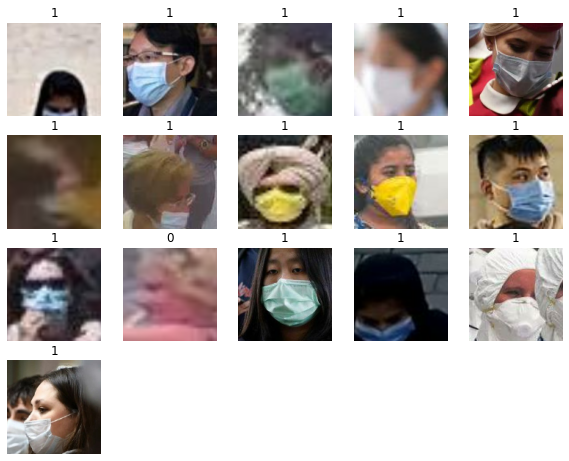

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(16):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

## 3. Development of Image Classification Model

Lets configure our custom Big Transfer Model, so that we can adapt it to our custom mask classification dataset:

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class MyBiTModel(keras.Model):
    """ Custom Big Transfer Model with new head for fine-tuning """
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        # initialise head with class no. and zeros
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        # use BiT model to extract embeddings from images
        bit_embedding = self.bit_model(images)
        
        # return logits
        return self.head(bit_embedding)

# create model instance
model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

Similarly to the image processing previously, lets set up all of our training settings so that it aligns with the Big Transfer training process documented within the original paper:

In [ ]:
# learning rate dependent on batch - as per paper
learning_rate = 0.003 * BATCH_SIZE / 512

# decay learning rate by ten times at each schedule boundary
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[learning_rate,
            learning_rate * 0.1,
            learning_rate * 0.01,
            learning_rate * 0.001])

# apply stochastic gradient descent optimiser, using our scheduler above
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# sparse categorical cross-entropy loss - since our labels are integers
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile model with chosen loss and accuracy as metric
model.compile(optimizer=optimizer, loss=loss_fn, 
              metrics=["accuracy"])

We'll also use a training callback so that we monitor the training progress, and keep the final model that achieved the best performance in terms of validation accuracy:

In [ ]:
# monitor val accuracy and stop when we start overfitting
train_callbacks = [keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True)]

lets just use 80 epochs for now. It probably won't reach this number, since the early callback will likely stop once we start overfitting to the data. If we need the best performance beyond this eventually, we can adjust the number of epochs based on the schedule length and steps per epoch (as shown in the commented out setting further below):

In [ ]:
# train & fine-tune model, gather training / val results
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=80,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks)

Epoch 1/80
10/10 [==============================] - 39s 1s/step - loss: 0.5317 - accuracy: 0.6469 - val_loss: 0.4035 - val_accuracy: 0.7740
Epoch 2/80
10/10 [==============================] - 9s 1s/step - loss: 0.4222 - accuracy: 0.7625 - val_loss: 0.3519 - val_accuracy: 0.8242
Epoch 3/80
10/10 [==============================] - 10s 1s/step - loss: 0.3687 - accuracy: 0.8188 - val_loss: 0.3742 - val_accuracy: 0.8135
Epoch 4/80
10/10 [==============================] - 10s 1s/step - loss: 0.3448 - accuracy: 0.8281 - val_loss: 0.3398 - val_accuracy: 0.8313
Epoch 5/80
10/10 [==============================] - 10s 1s/step - loss: 0.3398 - accuracy: 0.8406 - val_loss: 0.3442 - val_accuracy: 0.8246
Epoch 6/80
10/10 [==============================] - 9s 1s/step - loss: 0.3141 - accuracy: 0.8406 - val_loss: 0.3239 - val_accuracy: 0.8393
Epoch 7/80
10/10 [==============================] - 9s 1s/step - loss: 0.3851 - accuracy: 0.8125 - val_loss: 0.3611 - val_accuracy: 0.8255
Epoch 8/80
10/10 [=====

Lets look at our training and validation performance during training:

In [ ]:
history_df = pd.DataFrame(history.history)

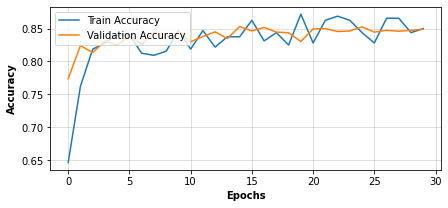

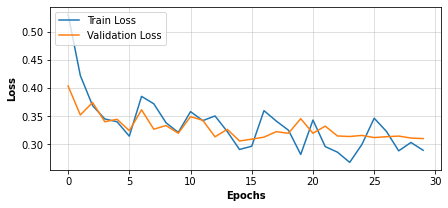

In [ ]:
history_df[['accuracy', 'val_accuracy']].plot(figsize=(7,3))
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend(loc="best")
plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
plt.grid(alpha=0.5)
plt.show()

history_df[['loss', 'val_loss']].plot(figsize=(7,3))
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend(loc="best")
plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
plt.grid(alpha=0.5)
plt.show()

Evidently the learning rate scheduling kicks in and the model goes from diminishing to improving performance. This is the reason why we need to ensure we train and fine-tune the model long enough to reap the results.

By comparing the pre-trained resnet models, it can be seen that the much larger and more complex models perform better in terms of final classification performance. However, the convenience, speed and efficiency of the smaller model(s), in comparison, far outweigh the longer computational times. 

Since we're interesting in applying our model in real-time (or near-real-time), we'll choose the fastest model (bit/m-r50x1).

In [ ]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

71/71 [==============================] - 10s 125ms/step - loss: 0.3055 - accuracy: 0.8530
Accuracy: 85.30%


Let's take some individual batches of validation data and make predictions:

In [ ]:
image_batch, label_batch = next(iter(pipeline_validation))
model.evaluate(image_batch, label_batch)

1/1 [==============================] - 1s 1s/step - loss: 0.3266 - accuracy: 0.8438


[0.32657456398010254, 0.84375]

In [ ]:
model.predict(image_batch)

array([[-3.4855754 ,  3.485576  ],
       [-4.1044884 ,  4.1044893 ],
       [ 0.31094468, -0.31094453],
       [-0.00955309,  0.00955347],
       [-0.7698346 ,  0.7698351 ],
       [ 1.054572  , -1.0545715 ],
       [ 0.951294  , -0.95129347],
       [-3.7080386 ,  3.7080393 ],
       [-2.4833505 ,  2.4833508 ],
       [-0.9143008 ,  0.91430116],
       [ 0.4299118 , -0.42991132],
       [-2.6930501 ,  2.6930504 ],
       [-1.1260495 ,  1.1260502 ],
       [-3.477645  ,  3.4776454 ],
       [ 2.3796468 , -2.3796473 ],
       [-1.1570898 ,  1.1570902 ],
       [-0.44306806,  0.4430686 ],
       [-4.1028132 ,  4.1028132 ],
       [-0.278213  ,  0.27821335],
       [-0.14780138,  0.14780185],
       [-0.35390282,  0.353903  ],
       [-1.3106656 ,  1.3106664 ],
       [-3.697279  ,  3.69728   ],
       [-2.7043102 ,  2.704311  ],
       [-0.34753394,  0.34753403],
       [-2.5252087 ,  2.525209  ],
       [-3.065875  ,  3.0658758 ],
       [ 0.01611409, -0.01611344],
       [-1.4839466 ,

These outputs are logits. In order to interpret them as probabilities, we can apply softmax to these values (along the second dimension - since this indicates the logit for each class output).

In [ ]:
layer = tf.keras.layers.Softmax()
layer(model.predict(image_batch)).numpy()

array([[9.3769166e-04, 9.9906236e-01],
       [2.7212477e-04, 9.9972790e-01],
       [6.5064812e-01, 3.4935191e-01],
       [4.9522349e-01, 5.0477648e-01],
       [1.7658331e-01, 8.2341671e-01],
       [8.9178872e-01, 1.0821130e-01],
       [8.7018412e-01, 1.2981592e-01],
       [6.0114230e-04, 9.9939883e-01],
       [6.9178971e-03, 9.9308211e-01],
       [1.3840491e-01, 8.6159509e-01],
       [7.0262367e-01, 2.9737630e-01],
       [4.5589176e-03, 9.9544108e-01],
       [9.5168501e-02, 9.0483153e-01],
       [9.5266860e-04, 9.9904734e-01],
       [9.9150121e-01, 8.4988093e-03],
       [8.9955375e-02, 9.1004467e-01],
       [2.9190776e-01, 7.0809227e-01],
       [2.7303802e-04, 9.9972695e-01],
       [3.6437473e-01, 6.3562524e-01],
       [4.2663264e-01, 5.7336730e-01],
       [3.3008385e-01, 6.6991615e-01],
       [6.7778066e-02, 9.3222189e-01],
       [6.1421015e-04, 9.9938571e-01],
       [4.4578500e-03, 9.9554211e-01],
       [3.3290663e-01, 6.6709334e-01],
       [6.3658715e-03, 9.

Lets make some predictions, with softmax, and visualise the outcomes along with the images:

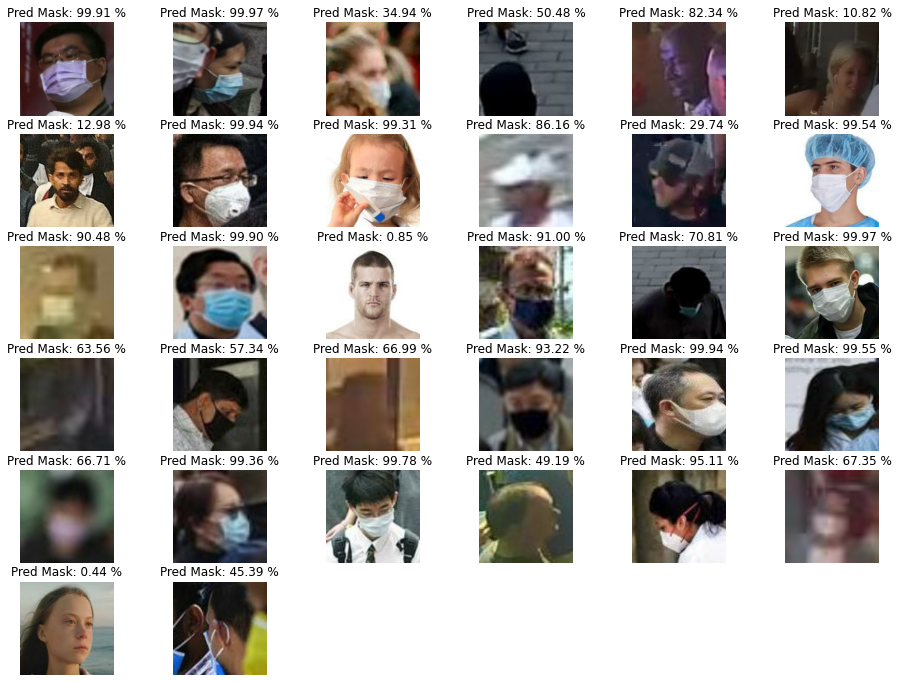

In [ ]:
image_batch_preds = layer(model.predict(image_batch)).numpy()

# lets view these images just to get an idea of what we predicted
plt.figure(figsize=(16, 12))
for n in range(BATCH_SIZE):
    ax = plt.subplot(6, 6, n + 1)
    plt.imshow(image_batch[n])
    plt.title(f"Pred Mask: {image_batch_preds[n, 1] * 100:.2f} %")
    plt.axis("off")

Our model appears to work well on those that are clear. However, it tends to struggle on those that are ambiguous, blurry and difficult to see. This is to be expected, gven the tough nature of the dataset and the low quality of some of the images.

## 4. Evaluation of Classification Metrics with trained model

Lets get some final validation / test metrics metrics to help evaluate our model after training. This includes:
- Accuracy
- Precision, Recall and F1 values
- Receiver Operator Characteristic Area under the Curve (ROC AUC)

To do this we'll first define some helper functions for our predictions:

In [ ]:
softmax_layer = tf.keras.layers.Softmax()

def model_predict_probs(model, image_batch, softmax=True):
    """ Helper function for making probability predictions 
        on an image batch """
    preds = model.predict(image_batch)
    if softmax:
        return softmax_layer(preds).numpy()
    else:
        return preds

def get_prediction_labels(preds, threshold=None):
    """ Get output prediction labels (0 = no_mask, 1 = mask) 
    
    Args:
        preds (np.array) : 2d array containing class probabilities.
        threshold (float) : class threshold, based on second preds column.
    """
    # if theshold chosen, find label based on probability
    if threshold is not None:
        return tf.where(preds[:, 1] >= threshold, 1, 0)
    # otherwise simply return argmax for class label
    else:
        return tf.argmax(preds, axis=1)

In [ ]:
class_names

['no_mask', 'with_mask']

In [ ]:
def plot_confusion_matrix(true_y, pred_y, 
                          title='Confusion Matrix', figsize=(7,5),
                          class_names=None):
    """ Plot a confusion matrix for predicted results """
    conf_matrix = confusion_matrix(true_y, pred_y)
    if class_names:
        index = [class_names[i] for i in np.unique(val_labels)]
    else:
        index = np.unique(true_y)
    conf_df = pd.DataFrame(conf_matrix, columns=np.unique(true_y), index=index)
    conf_df.index.name = 'Actual'
    conf_df.columns.name = 'Predicted'
    plt.figure(figsize = figsize)
    plt.title(title, weight="bold")
    sns.set(font_scale=1.4)
    sns.heatmap(conf_df, cmap="Blues", annot=True, 
                annot_kws={"size": 16}, fmt='g')
    plt.xticks(ticks=np.unique(val_labels) + 0.5, 
               labels=index)
    plt.show()
    return

def plot_roc_curve(labels, pred_probs, 
                   figsize=(7,6), title="ROC Curve"):
    """ Helper function for plotting ROC AUC Curves """
    # obtain true positive and false positive rates for roc_auc
    fpr, tpr, thresholds = roc_curve(labels, pred_probs[:, 1], 
                                     pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color='blue')
    plt.plot([0,1], [0, 1], label="Random Guessing", 
             linestyle=":", color='grey', alpha=0.6)
    plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Performance", 
             linestyle="--", color='black', alpha=0.6)
    plt.xlabel("False Positive Rate", weight='bold')
    plt.ylabel("True Positive Rate", weight='bold')
    plt.title(title, weight='bold')
    plt.legend(loc='best')
    plt.show()
    
def plot_prec_rec_curve(labels, pred_probs, 
                        figsize=(8,5), 
                        title="Precision-Recall Curve"):
    """ Helper function to plot the ROC AUC from given labels """
    # obtain true positive and false positive rates for roc_auc
    prec, rec, thresholds = precision_recall_curve(labels, 
                                                   pred_probs[:, 1], 
                                                   pos_label=1)
    prec_rec_auc = auc(rec, prec)
    plt.figure(figsize=figsize)
    plt.plot(prec, rec, 
             label=f"Precision-Recall AUC = {prec_rec_auc:.4f}", color='blue')
    plt.xlabel("Recall", weight='bold')
    plt.ylabel("Precision", weight='bold')
    plt.title(title, weight='bold')
    plt.legend(loc='best')
    plt.show()

Lets make predictions on our validation (and eventually the hold-out test) data, and measure the performance in terms of precision, recall, f1 score, and ROC AUC:

In [ ]:
val_preds = []
val_pred_probs = []
val_labels = []

# iterate through our validation dataset and make predictions
for val_img_batch, val_label_batch in tqdm(pipeline_validation):

        # get validation pred probabilities
        batch_probs = model_predict_probs(model, val_img_batch)

        # get class labels of predictions
        batch_pred_labels = get_prediction_labels(batch_probs)

        # append batch preds to our overall predict arrays
        val_preds.append(batch_pred_labels)
        val_pred_probs.append(batch_probs)
        val_labels.append(val_label_batch)


# convert into numpy array and flatten
val_preds = np.concatenate(val_preds, axis=0)
val_pred_probs = np.concatenate(val_pred_probs, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

100%|██████████| 71/71 [00:16<00:00,  4.28it/s]


In [ ]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       640
           1       0.90      0.89      0.90      1612

    accuracy                           0.85      2252
   macro avg       0.82      0.82      0.82      2252
weighted avg       0.85      0.85      0.85      2252



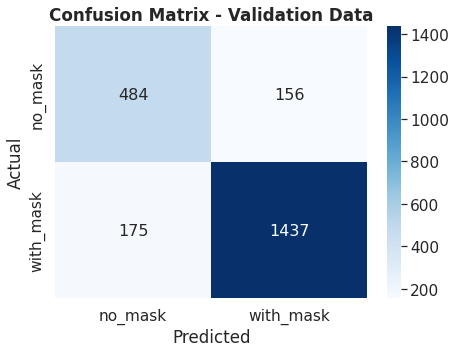

In [ ]:
plot_confusion_matrix(val_labels, val_preds, 
                      title="Confusion Matrix - Validation Data",
                      class_names=class_names)

The performance by default is good, but we can improve by reducing the number of false positives made throuh adjusting the prediction threshold, in line with our ROC Curve above. 

Through trial and error, a threshold of 0.7 (70%) obtains the best compromise of precision and recall, with an emphasis on lowering the number of false positives our model makes (erroneously predicting non-masked people as masked):

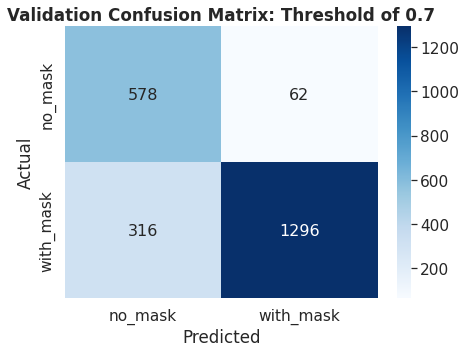

              precision    recall  f1-score   support

           0       0.90      0.65      0.75       894
           1       0.80      0.95      0.87      1358

    accuracy                           0.83      2252
   macro avg       0.85      0.80      0.81      2252
weighted avg       0.84      0.83      0.83      2252



In [ ]:
THRESHOLD = 0.7
val_preds_thresh = get_prediction_labels(val_pred_probs, threshold=THRESHOLD)

plot_confusion_matrix(val_labels, val_preds_thresh, 
            title=f"Validation Confusion Matrix: Threshold of {THRESHOLD}",
            class_names=class_names)

print(classification_report(val_preds_thresh, val_labels))

As shown, our confusion results are much more favourable after adjusting the threshold to 0.7.

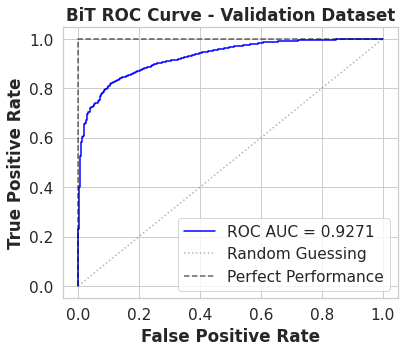

In [ ]:
sns.set_style('whitegrid')

# plot our ROC curve
plot_roc_curve(val_labels, val_pred_probs, 
               title="BiT ROC Curve - Validation Dataset", figsize=(6,5))

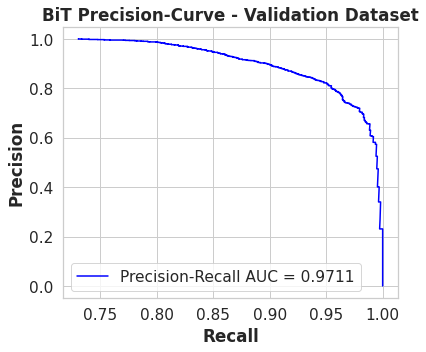

In [ ]:
sns.set_style('whitegrid')

# plot our precision-recall curve
plot_prec_rec_curve(val_labels, val_pred_probs, figsize=(6,5), 
                    title="BiT Precision-Curve - Validation Dataset")

Lets try getting our confusion matrix results again with an improved threshold, in order to lower the number of false positives (falsely predicting people have masks):

In [ ]:
val_pred_probs[:, 1]

array([0.89929426, 0.2129507 , 0.07400072, ..., 0.99655354, 0.998271  ,
       0.9989974 ], dtype=float32)

In [ ]:
get_prediction_labels(val_pred_probs, threshold=0.3)

<tf.Tensor: shape=(2252,), dtype=int32, numpy=array([1, 0, 0, ..., 1, 1, 1], dtype=int32)>

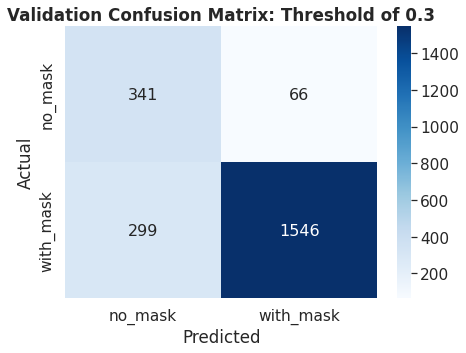

              precision    recall  f1-score   support

           0       0.53      0.84      0.65       407
           1       0.96      0.84      0.89      1845

    accuracy                           0.84      2252
   macro avg       0.75      0.84      0.77      2252
weighted avg       0.88      0.84      0.85      2252



In [ ]:
THRESHOLD = 0.7

val_preds_thresh = get_prediction_labels(val_pred_probs, threshold=THRESHOLD)

plot_confusion_matrix(val_preds_thresh, val_labels, 
            title=f"Validation Confusion Matrix: Threshold of {THRESHOLD}",
            class_names=class_names)

print(classification_report(val_preds_thresh, val_labels))

## 5. Saving Trained Model for use in the larger system

Save model so that it can be used for inference in the crowd monitoring platform:

In [ ]:
# define folder to save our model and config to
saved_model_dir = os.path.join(DRIVE_DATA_DIR, 'models')

In [ ]:
# save fine-tuned model to drive
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/ML_Data/Mask_Object_Detection/models/assets


INFO:tensorflow:Assets written to: drive/MyDrive/ML_Data/Mask_Object_Detection/models/assets


If we need to load the model and make predictions, we can do it like so:

In [ ]:
# Load saved model
trained_model = hub.KerasLayer(saved_model_dir, trainable=False)

## 6. Inference on new and unseen images:

In [ ]:
# define folder that contains our trained model
saved_model_dir = os.path.join(DRIVE_DATA_DIR, 'models')

# if not already done, load existing trained model
trained_model = hub.KerasLayer(saved_model_dir, trainable=False)

We'll also obtain our unseen dataset of images (without labels). This will test how well our model performs against imagery that has been extracted using AlphaPose features:

In [ ]:
# set paths to heldout test images
UNSEEN_TEST_FILENAME = 'test_set_extracted_regions.zip'
test_data_file = os.path.join(DRIVE_DATA_DIR, UNSEEN_TEST_FILENAME)

# unzip dataset move to local instance
!unzip {test_data_file} -d {INPUT_DIR}

Archive:  drive/MyDrive/ML_Data/Mask_Object_Detection/test_set_extracted_regions.zip
   creating: /content/extracted_regions/
  inflating: /content/extracted_regions/Apgar_Village maryland_broadwalk_27_region_9.jpg  
  inflating: /content/extracted_regions/.DS_Store  
  inflating: /content/__MACOSX/extracted_regions/._.DS_Store  
  inflating: /content/extracted_regions/00002937_region_1.jpg  
  inflating: /content/extracted_regions/bourbon_street bourbon_street22_1602369822.9287958_region_3.jpg  
  inflating: /content/extracted_regions/bourbon_street bourbon_street22_1602369822.9287958_region_2.jpg  
  inflating: /content/extracted_regions/00001542_region_6.jpg  
  inflating: /content/extracted_regions/00002937_region_0.jpg  
  inflating: /content/extracted_regions/00002937_region_2.jpg  
  inflating: /content/extracted_regions/00001266_region_4.jpg  
  inflating: /content/extracted_regions/00001542_region_4.jpg  
  inflating: /content/extracted_regions/bourbon_street bourbon_street22_

In [ ]:
TEST_DIR = '/content/extracted_regions'

We have no labels for this data, and so we need to define some further custom loading and preprocessing functions before our model can make predictions.

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  label_mode=None,
  image_size=IMG_SIZE,
  batch_size=None)

Found 58 files belonging to 1 classes.


In [ ]:
@tf.function
def preprocess_unlabelled_test(image):
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = image / 255.0
    return image

In [ ]:
# Unseen Test pipeline
pipeline_test = (
    test_ds.map(preprocess_unlabelled_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

Lets make predictions on just one batch first to ensure the unseen test set is loaded and can be processed correctly: 

In [ ]:
test_image_batch = next(iter(pipeline_test))

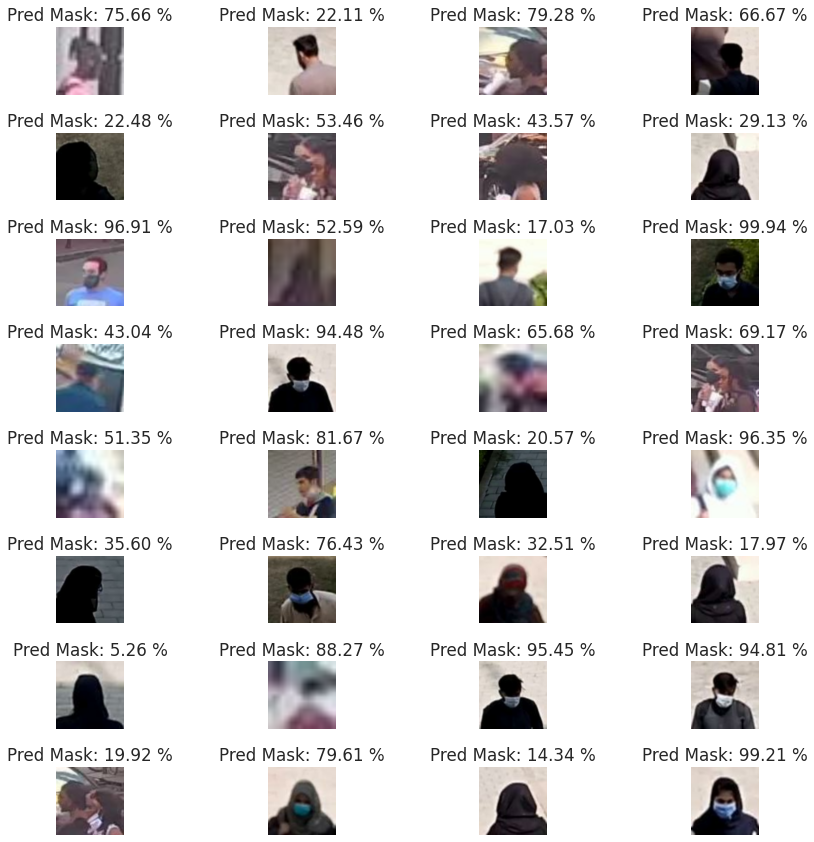

In [ ]:
layer = tf.keras.layers.Softmax()
unseen_batch_preds = layer(saved_module(test_image_batch)).numpy()

# lets view these images just to get an idea of what we predicted
plt.figure(figsize=(12, 12))
for n in range(BATCH_SIZE):
    ax = plt.subplot(8, 4, n + 1)
    plt.imshow(test_image_batch[n])
    plt.title(f"Pred Mask: {unseen_batch_preds[n, 0] * 100:.2f} %")
    plt.axis("off")
plt.tight_layout()
plt.show()

Lets make predictions on the entire dataset:

In [ ]:
test_preds = []
test_imgs = []

for test_batch in pipeline_test:
    batch_preds = layer(trained_module(test_batch)).numpy()
    test_preds.append(batch_preds)
    test_imgs.append(test_batch.numpy())

# convert into numpy array and flatten
test_preds = np.concatenate(test_preds, axis=0)
#test_preds = test_preds.reshape(test_preds.shape[0]*test_preds.shape[1], -1)

test_imgs = np.concatenate(test_imgs, axis=0)

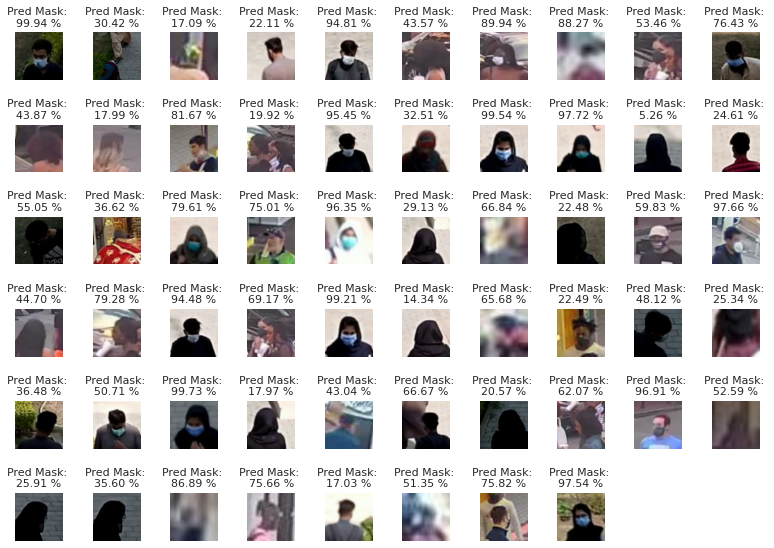

In [ ]:
# lets view all of our predictions
plt.figure(figsize=(11, 8))
n_images = min(test_preds.shape[0], 60)

# plot results for each image
for n in range(n_images):
    ax = plt.subplot(6, 10, n + 1)
    plt.imshow(test_imgs[n])
    plt.title(f"Pred Mask: \n{test_preds[n, 0] * 100:.2f} %", size=11)
    plt.axis("off")
plt.tight_layout()
plt.show()